In [4]:
!pip install pandas PyPDF2 nltk textblob wordcloud matplotlib scikit-learn gensim scipy==1.12.0

   ---------------------------------------- 0.0/45.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/45.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/45.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/45.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/45.8 MB ? eta -:--:--
    --------------------------------------- 1.0/45.8 MB 1.5 MB/s eta 0:00:31
    --------------------------------------- 1.0/45.8 MB 1.5 MB/s eta 0:00:31
   - -------------------------------------- 1.3/45.8 MB 1.2 MB/s eta 0:00:37
   - -------------------------------------- 1.8/45.8 MB 1.3 MB/s eta 0:00:34
   - -------------------------------------- 1.8/45.8 MB 1.3 MB/s eta 0:00:34
   -- ------------------------------------- 2.4/45.8 MB 1.3 MB/s eta 0:00:33
   -- ------------------------------------- 2.4/45.8 MB 1.3 MB/s eta 0:00:33
   -- ------------------------------------- 2.9/45.8 MB 1.4 MB/s eta 0:00:31
   -- ----------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.65 requires torchvision>=0.9.0, which is not installed.


STEP 1:Importing Libraries and downloading NLTK Data

In [ ]:
# Import all required libraries
import pandas as pd
import PyPDF2
import re
import matplotlib.pyplot as plt
from collections import Counter

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

# TextBlob for sentiment analysis
from textblob import TextBlob

# WordCloud for visualization
from wordcloud import WordCloud

# Scikit-learn for TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim for Topic Modelling (LDA)
import gensim
from gensim import corpora

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Step 2: import pdf and read pages


In [2]:

pdf_path = 'Tata Steel Annual Report 2023-24.pdf'

# Extracting text from each page
pdf_text = []
page_numbers = []
try:
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        for i, page in enumerate(reader.pages):
            pdf_text.append(page.extract_text())
            page_numbers.append(i + 1)
    print(f"Successfully read {len(reader.pages)} pages.")
except FileNotFoundError:
    print(f"Error: The file '{pdf_path}' was not found. Please check the file path and name.")

Successfully read 581 pages.


Step 3: Saving into Dataframe


In [3]:
# Create a DataFrame with the extracted text
df = pd.DataFrame({'page_number': page_numbers, 'original_text': pdf_text})

# Display the first 5 rows of the DataFrame
df.head()

,page_number,original_text
0,1,TRANSFORMING\nFOR TOMORROW\nIntegrated Report ...
1,2,TRANSFORMING \nFOR TOMORROW\n08 36 72Tata Ste...
2,3,"Solar panels installed at the cooling pond, Ta..."
3,4,Steel industry’s first crew of \nfemale firefi...
4,5,Shaping a Shaping a \ncleaner tomorrowcleane...


Step 4: Preprocessing data

In [4]:
# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """A function to clean text data."""
    if text is None:
        return ""
    text = text.lower()  # Convert to lower case
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    filtered_words = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_words)

# Apply the preprocessing function to the 'original_text' column
df['processed_text'] = df['original_text'].apply(preprocess_text)

# Display the original vs. processed text for the first few pages
df[['original_text', 'processed_text']].head()

,original_text,processed_text
0,TRANSFORMING\nFOR TOMORROW\nIntegrated Report ...,transforming tomorrow integrated report annual...
1,TRANSFORMING \nFOR TOMORROW\n08 36 72Tata Ste...,transforming tomorrow tata steel aims become r...
2,"Solar panels installed at the cooling pond, Ta...",solar panels installed cooling pond tata steel...
3,Steel industry’s first crew of \nfemale firefi...,steel industrys first crew female firefighters...
4,Shaping a Shaping a \ncleaner tomorrowcleane...,shaping shaping cleaner tomorrowcleaner tomorr...


Step 5 : Sent Tokenize and calculate sentiment for each sentence(Text Blob library)

In [5]:
# Tokenize by sentence and calculate sentiment
sentiment_data = []
for index, row in df.iterrows():
    # Use the original text for sentence tokenization to preserve sentence structure
    sentences = sent_tokenize(row['original_text'])
    for sentence in sentences:
        blob = TextBlob(sentence)
        sentiment_data.append({
            'page_number': row['page_number'],
            'sentence': sentence,
            'polarity': blob.sentiment.polarity,      # Range: [-1, 1]
            'subjectivity': blob.sentiment.subjectivity  # Range: [0, 1]
        })

# Create a new DataFrame for sentiment analysis results
sentiment_df = pd.DataFrame(sentiment_data)

print("Sentiment Analysis Results:")
sentiment_df.head()

Sentiment Analysis Results:


,page_number,sentence,polarity,subjectivity
0,1,TRANSFORMING\nFOR TOMORROW\nIntegrated Report ...,0.000000,0.000000
1,2,TRANSFORMING \nFOR TOMORROW\n08 36 72Tata Ste...,0.166667,0.166667
2,2,From \nsetting up Asia’s first integrated stee...,0.240000,0.496667
3,2,One of the most geographically diversified ste...,0.400000,0.550000
4,2,Pursuing the ambitious target of achieving Net...,0.125000,0.375000


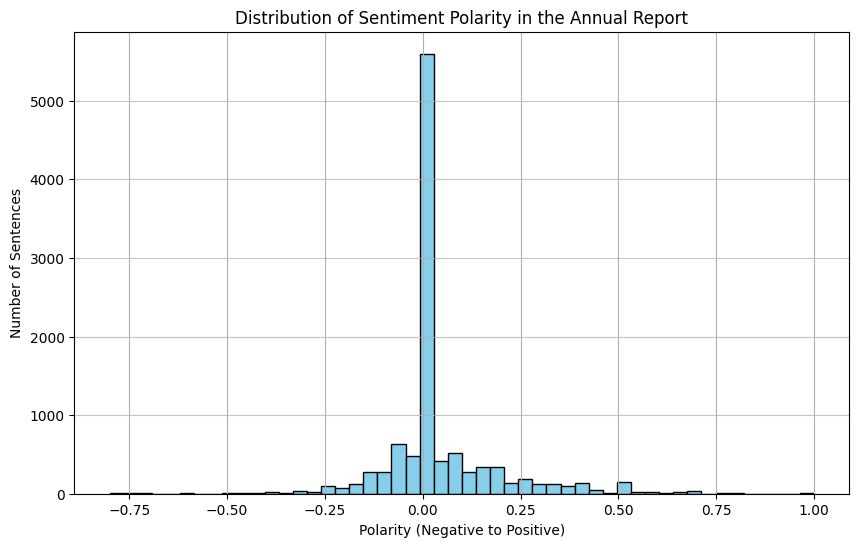

In [6]:
# Plot a histogram of the sentiment polarity
plt.figure(figsize=(10, 6))
sentiment_df['polarity'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Polarity in the Annual Report')
plt.xlabel('Polarity (Negative to Positive)')
plt.ylabel('Number of Sentences')
plt.grid(axis='y', alpha=0.75)
plt.show()

Step 6: Word Tokenize and preprocess

In [7]:
# Tokenize the processed text into words
df['tokens'] = df['processed_text'].apply(word_tokenize)

# Display the tokens for the first 5 pages
df[['page_number', 'tokens']].head()

,page_number,tokens
0,1,"[transforming, tomorrow, integrated, report, a..."
1,2,"[transforming, tomorrow, tata, steel, aims, be..."
2,3,"[solar, panels, installed, cooling, pond, tata..."
3,4,"[steel, industrys, first, crew, female, firefi..."
4,5,"[shaping, shaping, cleaner, tomorrowcleaner, t..."


Step 7: Frequent words and Wordcloud


In [8]:
# Combine all tokens from all pages into a single list
all_words = [word for tokens_list in df['tokens'] for word in tokens_list]

# Calculate the frequency of each word
word_freq = Counter(all_words)

# Display the 20 most common words
print("Top 20 most frequent words:")
print(word_freq.most_common(20))

Top 20 most frequent words:
[('steel', 2857), ('tata', 2547), ('company', 2080), ('year', 1824), ('financial', 1534), ('crore', 1431), ('limited', 1345), ('march', 1266), ('fy', 978), ('report', 975), ('h', 947), ('value', 860), ('annual', 809), ('integrated', 784), ('accounts', 712), ('statements', 709), ('th', 683), ('india', 670), ('f', 669), ('assets', 635)]


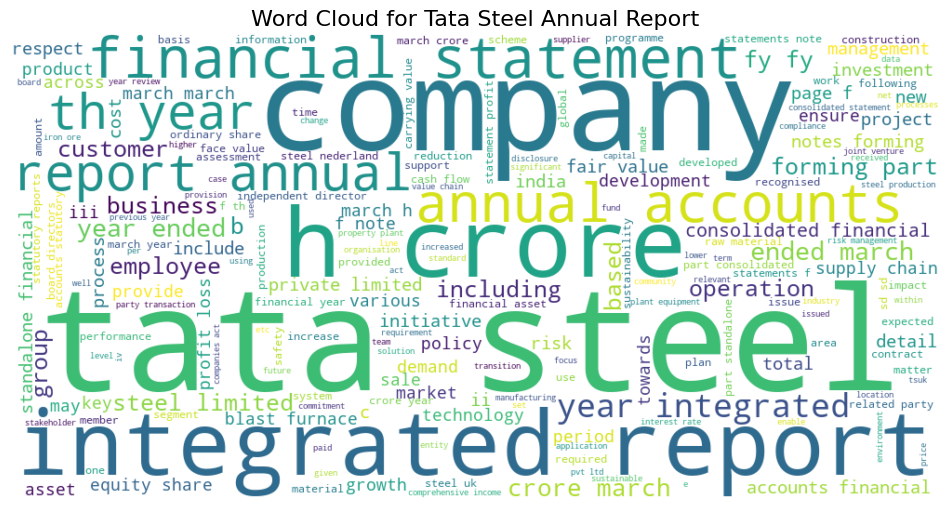

In [9]:
# Join all the processed words to create a single text block for the word cloud
wordcloud_text = " ".join(all_words)

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(wordcloud_text)

# Display the word cloud image
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Tata Steel Annual Report', fontsize=16)
plt.show()

Step 8:Convert to TFTDF or Document Term Matrix

In [ ]:
# Initialize the TF-IDF Vectorizer
# limiting 1000 features to keep the matrix manageable
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Create the TF-IDF matrix from the processed text
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

# Print the shape of the resulting matrix (pages x unique words)
print("Shape of the TF-IDF Matrix:", tfidf_matrix.shape)

Shape of the TF-IDF Matrix: (581, 1000)


Step 9: Build Topic Modelling (Latent Dirichlect Allocation with Gibbs Sampling). 
Number of Topics are 10

In [11]:
# Create the dictionary and corpus needed for the LDA model
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

# Build the LDA model with 10 topics
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=100,
    passes=10
)

# Print the keywords for each of the 10 topics
print("\nDiscovered Topics and their Top Keywords:")
topics = lda_model.print_topics(num_words=10)
for topic_num, topic_words in topics:
    print(f"Topic #{topic_num+1}: {topic_words}")


Discovered Topics and their Top Keywords:
Topic #1: 0.036*"limited" + 0.029*"company" + 0.021*"tata" + 0.017*"steel" + 0.009*"board" + 0.009*"ltd" + 0.008*"private" + 0.007*"shares" + 0.006*"mr" + 0.006*"year"
Topic #2: 0.013*"tata" + 0.012*"company" + 0.011*"steel" + 0.007*"report" + 0.007*"management" + 0.007*"board" + 0.007*"business" + 0.005*"also" + 0.005*"policy" + 0.005*"integrated"
Topic #3: 0.021*"crore" + 0.016*"tata" + 0.015*"steel" + 0.013*"company" + 0.012*"march" + 0.012*"safety" + 0.008*"h" + 0.007*"limited" + 0.006*"loan" + 0.006*"increase"
Topic #4: 0.031*"year" + 0.029*"crore" + 0.027*"march" + 0.023*"h" + 0.020*"f" + 0.013*"financial" + 0.013*"net" + 0.012*"ended" + 0.012*"assets" + 0.012*"tax"
Topic #5: 0.014*"crore" + 0.011*"march" + 0.009*"court" + 0.009*"ü" + 0.008*"year" + 0.008*"company" + 0.007*"amount" + 0.007*"scheme" + 0.007*"tata" + 0.006*"financial"
Topic #6: 0.028*"steel" + 0.018*"tata" + 0.010*"fy" + 0.006*"year" + 0.005*"production" + 0.005*"company" 